In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from itertools import combinations
import collections

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from transformers import BertForSequenceClassification, BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim

I0509 15:35:45.648100 139755243960128 file_utils.py:41] PyTorch version 1.2.0 available.


In [3]:
DATA_FILE = './files/data/processed_08_04.npy'

### Обработка данных

In [4]:
data = pd.DataFrame(np.load(DATA_FILE), columns=['y','words','text_y'])
print(f'Кол-во примеров: {data.shape[0]}, кол-во классов {len(set(data["y"]))}') 


Кол-во примеров: 147636, кол-во классов 291


**1) Удаляем дубликаты**  


In [5]:
data['sentence'] = data['words'].apply(lambda x: ' '.join(x))
data = data.drop_duplicates(subset=['sentence','y'])
print('Top 15 классов')
class_count = data['y'].value_counts()
class_count[:15]  

Top 15 классов


15     10761
12      8873
9       8173
14      8118
271     5778
20      5392
16      5099
2       4369
6       4239
7       4239
1       3914
22      3410
21      3209
11      3101
48      2785
Name: y, dtype: int64

**2) Удаляем примеры нулевой длины**  


In [6]:
print(f"кол-во предложений с длиной 0: {data['words'].apply(lambda x: len(x)==0).sum()}")
data = data[data['words'].apply(lambda x: len(x) > 0)]

кол-во предложений с длиной 0: 12


Заметим, что предложения не уникальны. Одно и тоже предложение может принадлежать разным классам.



In [7]:
print(f"Кол-во уникальных предложений: {len(data['sentence'].unique())}")
print('Какое кол-во разных классов может приходится на 1 предложение')
x = data.groupby('sentence')['y'].apply(lambda x: len(set(x)))
pd.value_counts(x.values)

Кол-во уникальных предложений: 94595
Какое кол-во разных классов может приходится на 1 предложение


1     71601
2     10128
3      4942
4      4048
5      2132
6       996
7       471
8       154
9        60
10       47
12        6
11        4
21        2
13        1
66        1
19        1
22        1
dtype: int64

Видно, что больше 20К предложений имеют 2 и более класса. Удалим примеры с 6 и более классами. 

In [8]:
sentence_target = data.groupby(['sentence'])['y'].apply(lambda x: list(set(x))).reset_index()
sentence_target = sentence_target[sentence_target['y'].apply(lambda x: len(x) < 6)]

**4) Если одно предложение относится к разным классам, то выбираем наиболее популярный класс**

In [9]:
sentence_target['true_y'] = sentence_target['y'].apply(lambda x: class_count.loc[x].sort_values().index[-1] 
                                                       if len(x) > 1 else x[0])
sentence_target.head()

,sentence,y,true_y
0,action plans mis отсутствовать возможность вно...,[153],153
1,android телефон клиент подвергнуться мошенниче...,[51],51
2,aс екс кредитный договор автоматический режим ...,"[48, 50, 124]",48
3,bankhelper представлять трудность однозначно в...,[48],48
4,cccp tomsk mail ru просить скорректировать рол...,[1],1


**5) Все классы с кол-вом примеров меньше 200 объединим в один класс.** 

In [10]:
class_count = sentence_target['true_y'].value_counts()
rare_calsses = class_count.index[class_count < 200]
print(f'Всего классов: {class_count.shape[0]}, кол-во класов с меньше 200 примерами {rare_calsses.shape[0]}')
print('Доля примеров, которые объединяются в 1 класс',
      class_count[class_count < 200].sum() / sum(class_count))

Всего классов: 287, кол-во класов с меньше 200 примерами 208
Доля примеров, которые объединяются в 1 класс 0.09543246707089853


In [11]:
sentence_target['common_y'] = sentence_target['true_y'].apply(lambda x: -1 if x in rare_calsses else x)
sentence_target.head()

,sentence,y,true_y,common_y
0,action plans mis отсутствовать возможность вно...,[153],153,-1
1,android телефон клиент подвергнуться мошенниче...,[51],51,-1
2,aс екс кредитный договор автоматический режим ...,"[48, 50, 124]",48,48
3,bankhelper представлять трудность однозначно в...,[48],48,48
4,cccp tomsk mail ru просить скорректировать рол...,[1],1,1


### Определяем максимальную длину последовательности

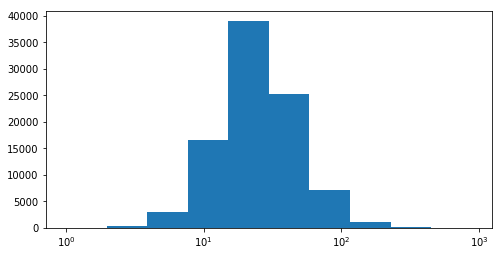

In [12]:
sent_len = []
for sample in (sentence_target['sentence']):
    sent_len.append(len(sample.split()))
sent_len = np.array(sent_len)

plt.figure(figsize=(8, 4))
plt.hist(np.log10(sent_len[sent_len!=0]));
# plt.xticks(range(7), [int(np.exp(i)) for i in range(7)]);
plt.xticks([0, 1, 2, 3], ['$10^0$', '$10^1$','$10^2$', '$10^3$']);

# # plt.title('Длина текста (в словах)')
#  log = True
# plt.hist(sent_len[sent_len!=0], bins=20);
# plt.xscale('log')


In [13]:
print(f'98% примеров имеют длину текста <= {np.percentile(sent_len, 98):.0f} + 2 токена для начала и конца')

98% примеров имеют длину текста <= 100 + 2 токена для начала и конца


In [14]:
MAX_LEN = 102

### Поделим на Train, Dev, Test

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
strat = sentence_target['common_y'].values
train_data, test_data = train_test_split(sentence_target, test_size=0.4, random_state=42, stratify=strat)
test_data, dev_data = train_test_split(test_data, test_size=0.5, random_state=42)

print(train_data.shape, test_data.shape, dev_data.shape)

(55710, 4) (18570, 4) (18571, 4)


**Все классы переводим в диапазон от 0 до кол-ва классов**

In [17]:
target_mapping = pd.value_counts(train_data['common_y'])
target_mapping = dict(zip(target_mapping.index, range(len(target_mapping))))
num_classes = len(target_mapping)
print('Кол-во классов', num_classes)


Кол-во классов 80


In [18]:
train_data['target'] = train_data['common_y'].apply(lambda x: target_mapping[x])
test_data['target'] = test_data['common_y'].apply(lambda x: target_mapping[x])
dev_data['target'] = dev_data['common_y'].apply(lambda x: target_mapping[x])


/home/kate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
train_data['id'] = np.arange(len(train_data))
test_data['id'] = np.arange(len(test_data))
dev_data['id'] = np.arange(len(dev_data))

train_data.head()

/home/kate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,sentence,y,true_y,common_y,target,id
19958,заявка возвратить доработка следующий причина ...,[14],14,14,3,0
38980,клиент обратиться уточнение информация защита ...,[271],271,271,2,1
28,cлучай отсутствие резервный копия криптоключ у...,[67],67,67,56,2
22256,заявка возвратить доработка следующий причина ...,[14],14,14,3,3
75734,расхождение мпп мотивационный калькулятор,[41],41,41,10,4


### Формирование выборок для LSTM

Сохраняем преобразованные в набор индексов предложения train, test, dev в папку 'files/data/tokens/'

In [20]:
def _build_vocab(data):
    counter = collections.Counter()
    for sample in data['sentence']:
        counter.update(collections.Counter(sample.split()))
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(1, len(words)+1)))
    word_to_id['PAD'] = 0
    return word_to_id

In [21]:
word_to_id = _build_vocab(train_data)

In [22]:
def split_by_tokens(data, word_to_id):
    data_tokens = []
    targets = []
    idx = []
    
    for i, sample in data.iterrows():
        sent = sample['sentence']
        target = sample['target']
        idx.append(sample['id'])
        tokens = [word_to_id[x] for x in sent.split() if x in word_to_id][:MAX_LEN]
        tokens = tokens + [word_to_id['PAD']] * (MAX_LEN - len(tokens))
        
        data_tokens.append(tokens)
        targets.append(target)
    df = pd.DataFrame(data_tokens)    
    df['target'] = targets
    df['id'] = idx
    return df

In [23]:
tokens_train = split_by_tokens(train_data, word_to_id)
tokens_test = split_by_tokens(test_data, word_to_id)
tokens_dev = split_by_tokens(dev_data, word_to_id)

In [24]:
tokens_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,target,id
0,2,21,20,16,9,218,73,6,80,25547,...,0,0,0,0,0,0,0,0,3,0
1,1,32,225,13,924,441,7,418,1247,26,...,0,0,0,0,0,0,0,0,2,1


In [25]:
data_path = 'files/data/'
lstm_data_path = data_path + 'tokens/'

os.makedirs(lstm_data_path, exist_ok=True)


In [26]:
tokens_train.to_csv(lstm_data_path + 'tokens_train.csv', index=False)
tokens_test.to_csv(lstm_data_path + 'tokens_test.csv', index=False)
tokens_dev.to_csv(lstm_data_path + 'tokens_dev.csv', index=False)

In [27]:
import json
json.dump(word_to_id, open(data_path + 'word_to_id.json', 'w'))

### Формирование выборок для Bert

Каждое предложение токенизируем с помощью BertTokenizer, заполняем 0 до максимальной длинны, считаем маску и сохраняем в 'files/data/bert_data/'

In [28]:
from transformers import BertForSequenceClassification, BertModel, BertTokenizer


In [29]:
BERT_PATH = './files/bert/rubert_cased_L-12_H-768_A-12_pt/'
tokenizer = BertTokenizer.from_pretrained(BERT_PATH)


I0509 15:36:30.532302 139755243960128 tokenization_utils.py:420] Model name './files/bert/rubert_cased_L-12_H-768_A-12_pt/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, bert-base-finnish-uncased-v1, bert-base-dutch-cased). Assuming './files/bert/rubert_cased_L-12_H-768_A-12_pt/' is a path, a model identifier, or url to a directory containing tokenizer files.
I0509 15:36:30.533077 139755243960128 tokenization_utils.py:449] Didn't find file ./files/bert/rubert_cased_L-12_H-768_A-12_pt/added_tokens.json. We won't load 

In [30]:
def make_dataset_bert(data):
    ids_target = []
    for i, sample in data.iterrows():
        sent = sample['sentence']
        t = sample['target']
        encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
        encoded_dict['input_ids'] = encoded_dict['input_ids'][0]
        encoded_dict['token_type_ids'] = encoded_dict['token_type_ids'][0]
        encoded_dict['attention_mask'] = encoded_dict['attention_mask'][0]
        
        sample_info = {'sent': sent,
                       'data': encoded_dict,
                        'target' : t,
                      'id': sample['id']}
        ids_target.append(sample_info)
    return ids_target

In [31]:
bert_data_train = make_dataset_bert(train_data)
bert_data_test = make_dataset_bert(test_data)
bert_data_dev = make_dataset_bert(dev_data)

In [32]:
bert_data_path = data_path + 'bert_data/'
os.makedirs(bert_data_path, exist_ok=True)


In [33]:
np.save(bert_data_path + 'train.npy', bert_data_train)
np.save(bert_data_path + 'test.npy', bert_data_test)
np.save(bert_data_path + 'dev.npy', bert_data_dev)